In [18]:
# =============================================================================
# Model Prediction Testing - 100 Random Samples
# =============================================================================

import pandas as pd
import numpy as np
import pickle
import dill
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("🚀 Starting Model Prediction Testing")
print("=" * 100)

🚀 Starting Model Prediction Testing


In [19]:
# =============================================================================
# Cell 1: Load All Required Models and Data
# =============================================================================

print("\n📂 Loading saved models and data...")

# Load preprocessed data
try:
    with open("../src/models/processed_data.pkl", "rb") as f:
        processed_data = dill.load(f)
    df_processed = processed_data["df"]
    preprocessing_functions = processed_data["preprocessing_functions"]
    print(f"✅ Preprocessed data loaded: {df_processed.shape}")
except Exception as e:
    print(f"❌ Error loading processed_data.pkl: {e}")

# Load feature engineering components
try:
    with open('../src/models/tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
    print("✅ TF-IDF vectorizer loaded")
except Exception as e:
    print(f"❌ Error loading TF-IDF vectorizer: {e}")

try:
    with open('../src/models/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("✅ Scaler loaded")
except Exception as e:
    print(f"❌ Error loading scaler: {e}")

try:
    with open('../src/models/feature_info.pkl', 'rb') as f:
        feature_info = pickle.load(f)
    numerical_features = feature_info['numerical_features']
    print("✅ Feature info loaded")
except Exception as e:
    print(f"❌ Error loading feature_info.pkl: {e}")

# Load the best trained model
try:
    with open("../src/models/best_classification_model.pkl", "rb") as f:
        best_model_dict = pickle.load(f)
    
    best_model = best_model_dict["estimator"]
    model_name = best_model_dict["model_name"]
    label_encoder = best_model_dict.get("label_encoder", None)
    
    print(f"✅ Best model loaded: {model_name}")
    print(f"   • Test Accuracy: {best_model_dict['test_accuracy']:.1%}")
    print(f"   • Weighted F1: {best_model_dict['weighted_f1']:.3f}")
    
except Exception as e:
    print(f"❌ Error loading best model: {e}")


📂 Loading saved models and data...
✅ Preprocessed data loaded: (13855, 20)
✅ TF-IDF vectorizer loaded
✅ Scaler loaded
✅ Feature info loaded
✅ Best model loaded: Stacking
   • Test Accuracy: 73.3%
   • Weighted F1: 0.725


In [20]:
# =============================================================================
# Cell 2: Select 100 Random Samples
# =============================================================================

print("\n🎲 Selecting 100 random samples for testing...")

# Set random seed for reproducibility
np.random.seed(42)

# Sample 100 random reviews
test_samples = df_processed.sample(n=100, random_state=42).reset_index(drop=True)

print(f"✅ Selected {len(test_samples)} random samples")
print(f"   • Rating distribution in sample:")

rating_counts = test_samples['ReviewRating'].value_counts().sort_index()
for rating, count in rating_counts.items():
    print(f"     {rating} stars: {count} reviews")


🎲 Selecting 100 random samples for testing...
✅ Selected 100 random samples
   • Rating distribution in sample:
     1 stars: 53 reviews
     2 stars: 9 reviews
     3 stars: 7 reviews
     4 stars: 3 reviews
     5 stars: 28 reviews


In [21]:
# =============================================================================
# Cell 3: Prepare Features for Prediction
# =============================================================================

print("\n🔧 Preparing features for prediction...")

# Extract text and numerical features
texts = test_samples['processed_text'].values
true_ratings = test_samples['ReviewRating'].values

# TF-IDF features
tfidf_features = tfidf_vectorizer.transform(texts)
print(f"✅ TF-IDF features created: {tfidf_features.shape}")

# Numerical features
numerical_data = test_samples[numerical_features].values
numerical_features_scaled = scaler.transform(numerical_data)
print(f"✅ Numerical features scaled: {numerical_features_scaled.shape}")

# Combine features (sparse + dense)
from scipy.sparse import hstack
combined_features = hstack([tfidf_features, numerical_features_scaled])
print(f"✅ Combined features: {combined_features.shape}")


🔧 Preparing features for prediction...
✅ TF-IDF features created: (100, 5000)
✅ Numerical features scaled: (100, 11)
✅ Combined features: (100, 5011)


In [22]:
# =============================================================================
# Cell 4: Make Predictions
# =============================================================================

print("\n🔮 Making predictions...")

# Make predictions
predicted_ratings = best_model.predict(combined_features)

# Get prediction probabilities if available
try:
    prediction_probs = best_model.predict_proba(combined_features)
    has_probabilities = True
    print("✅ Prediction probabilities available")
except:
    has_probabilities = False
    print("ℹ️ No prediction probabilities available for this model")

print(f"✅ Predictions completed for {len(predicted_ratings)} samples")


🔮 Making predictions...
✅ Prediction probabilities available
✅ Predictions completed for 100 samples


In [23]:
# -------------------------------------------------------------------------
# OPTIONAL: down-weight the probability of class 3★ by 20 %
# ---------------------------------------------------------------------------

APPLY_PENALTY = True       

if APPLY_PENALTY and hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(combined_features).copy()

    # index of class 3★ in model.classes_ (check your label order!)
    idx_3 = list(best_model.classes_).index(3)

    # 1) shrink probability of class 3 by 20 %
    proba[:, idx_3] *= 0.80

    # 2) renormalise rows so they sum to 1
    proba = proba / proba.sum(axis=1, keepdims=True)

    # 3) final label = argmax
    predicted_ratings = best_model.classes_[proba.argmax(axis=1)]

    prediction_probs  = proba
    has_probabilities = True
    print("⚡ Applied 20 % penalty to class 3★ probabilities")

    # Debug: how many 3★ predictions before & after
    raw_pred  = best_model.predict(combined_features)
    pen_pred  = predicted_ratings          # after penalty

    before = np.mean(raw_pred == 3)
    after  = np.mean(pen_pred == 3)

    print(f"Share of 3★ predictions   before: {before:.2%}")
    print(f"                           after : {after:.2%}")
else:
    print("ℹ️ Penalty not applied (either disabled or model has no predict_proba)")

⚡ Applied 20 % penalty to class 3★ probabilities
Share of 3★ predictions   before: 83.00%
                           after : 14.00%


In [24]:
# =============================================================================
# Cell 5: Display Sample Results
# =============================================================================

print("\n📊 Sample Prediction Results")
print("=" * 80)

# Create results dataframe
results_df = pd.DataFrame({
    'ReviewText': test_samples['ReviewText'].str[:250] + '...', 
    'ProcessedText': test_samples['processed_text'].str[:250] + '...',  
    'TrueRating': true_ratings,
    'PredictedRating': predicted_ratings,
    'Correct': true_ratings == predicted_ratings
})

# Show first 100 results in detail
print("\n🔍 Detailed Results (First 100 samples):")
print("-" * 80)

for i in range(min(100, len(results_df))):
    row = results_df.iloc[i]
    status = "✅ CORRECT" if row['Correct'] else "❌ WRONG"
    
    print(f"\nSample {i+1}: {status}")
    print(f"Original Text: {row['ReviewText']}")
    print(f"Processed Text: {row['ProcessedText']}")
    print(f"True Rating: {row['TrueRating']} ⭐ | Predicted: {row['PredictedRating']} ⭐")
    
    if has_probabilities:
        probs = prediction_probs[i]
        prob_str = " | ".join([f"{j+1}⭐: {prob:.2f}" for j, prob in enumerate(probs)])
        print(f"Probabilities: {prob_str}")


📊 Sample Prediction Results

🔍 Detailed Results (First 100 samples):
--------------------------------------------------------------------------------

Sample 1: ✅ CORRECT
Original Text: Don’t be fooled by their coupon deals. You only have a week to use then. Spent money to get coupons and had to spend more to claim them. But they ran out after a week. How can anyone spend £200 here. Items themselves well you get what you pay for. Ch...
Processed Text: dont fooled coupon deal week use spent money get coupon spend claim ran week anyone spend item well get pay check thoroughly buying couple thing thought buying actually different...
True Rating: 2 ⭐ | Predicted: 2 ⭐
Probabilities: 1⭐: 0.13 | 2⭐: 0.29 | 3⭐: 0.29 | 4⭐: 0.25 | 5⭐: 0.04

Sample 2: ❌ WRONG
Original Text: They are always throwing the packets into the forest behind the mail boxes. Packets are always full of bugs and wet....
Processed Text: always throwing packet forest behind mail box packet always full bug wet...
True Rating: 


🔧 Smart sentiment grouping (Δ > 1 only) — based on probability distribution
🎨 Color-coded Results Table (showing first 100 rows):


Index,True★,Pred★,Adj★,Group True,Group Pred,Group Adj
1,2⭐,2⭐,2⭐,neg,neg,neg
2,1⭐,2⭐,2⭐,neg,neg,neg
3,1⭐,2⭐,2⭐,neg,neg,neg
4,2⭐,4⭐,2⭐,neg,pos,neg
5,1⭐,1⭐,1⭐,neg,neg,neg
6,1⭐,3⭐,1⭐,neg,neu,neg
7,5⭐,5⭐,5⭐,pos,pos,pos
8,3⭐,2⭐,2⭐,neu,neg,neg
9,1⭐,1⭐,1⭐,neg,neg,neg
10,4⭐,4⭐,4⭐,pos,pos,pos



📊 Enhanced Prediction Accuracy Visualization:


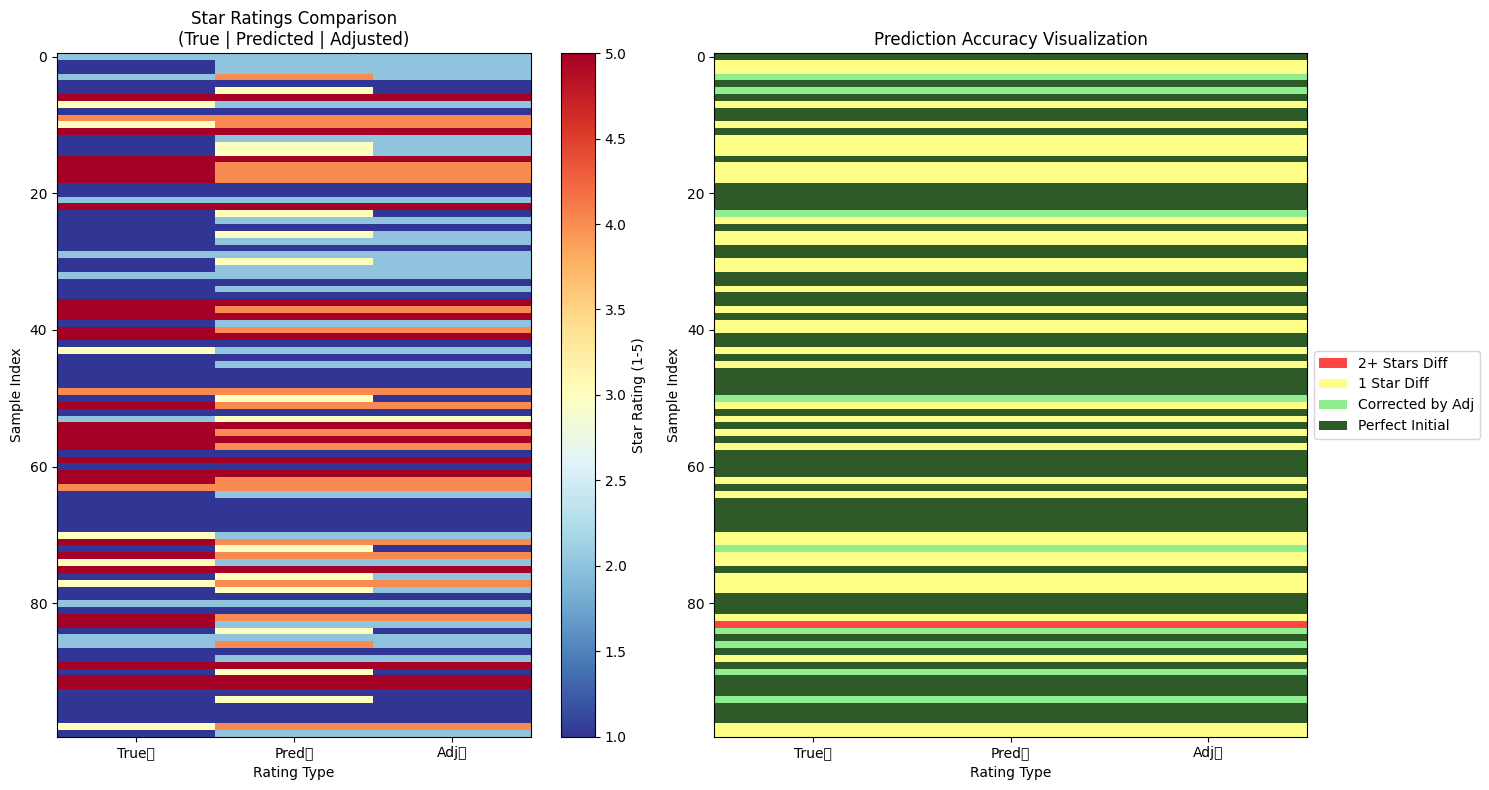


📈 Prediction Quality Summary:
🟢 Perfect Initial Predictions:  52 (52.0%)
🟡 Corrected by Adjustment:       9 (9.0%)
🟨 Close Predictions (1 diff):   38 (38.0%)
🔴 Poor Predictions (2+ diff):    1 (1.0%)
📊 Total Samples: 100


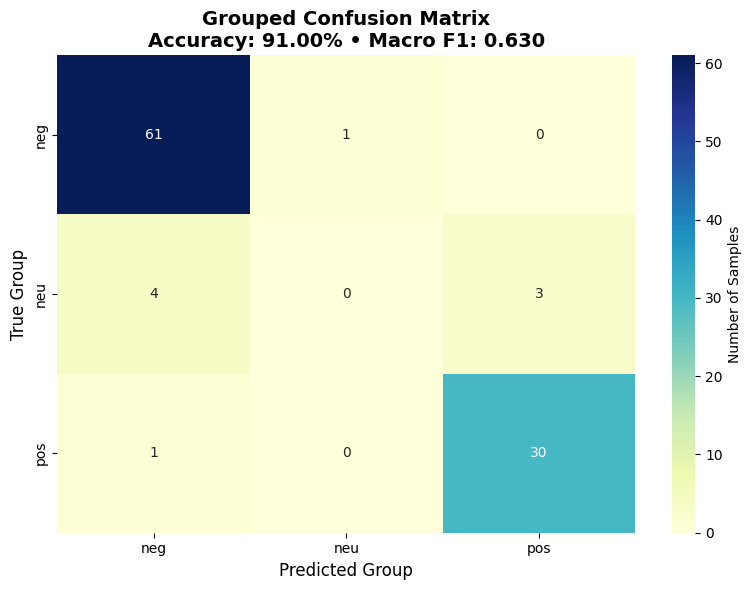


🔴 Worst Predictions Analysis (2+ Stars Difference)
Found 1 samples with 2+ star difference:
--------------------------------------------------------------------------------

🔥 Worst Prediction #1 (Sample Index: 84)
True: 5⭐ | Predicted: 2⭐ | Adjusted: 2⭐
Difference: 3 stars
Original Text: Why the full everyone here is complaining only about damaged packages or delivery problems. You handicapped or so ? You review should be over temu , and not about ups or dhl .I should make a a review over trustpilot , looks like we can’t count on them anymore ....
Processed Text: full everyone complaining damaged package delivery problem handicapped review temu ups dhl make review trustpilot look like cant count anymore...
Probabilities: 1⭐: 0.170 | 2⭐: 0.304 | 3⭐: 0.225 | 4⭐: 0.243 | 5⭐: 0.057
------------------------------------------------------------

✅ Analysis complete! Grouped accuracy: 91.00%, Macro F1: 0.630, Weighted F1: 0.882


In [25]:
# -------------------------------------------------------------------------
# 5b) Enhanced Sentiment Grouping – Smart adjustment with color visualization
# -------------------------------------------------------------------------

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

print("\n🔧 Smart sentiment grouping (Δ > 1 only) — based on probability distribution")
print("=" * 90)

# Dictionaries
group_of   = {1: "neg", 2: "neg", 3: "neu", 4: "pos", 5: "pos"}
group2star = {"neg": [1, 2], "neu": [3], "pos": [4, 5]}
star_emoji = {i: f"{i}⭐" for i in range(1, 6)}

# Initial grouping
group_true = np.array([group_of[t] for t in true_ratings])
group_pred = np.array([group_of[p] for p in predicted_ratings])
adj_star   = predicted_ratings.copy()

# Adjustment only for difference > 1
if has_probabilities:
    class_indices = {cls: idx for idx, cls in enumerate(best_model.classes_)}

    #---------------------------
    # 1) raise probability of class 3 to its original value for the group comparison
    proba[:, idx_3] *= 1

    # 2) renormalise rows so they sum to 1
    proba = proba / proba.sum(axis=1, keepdims=True)
    
    prediction_probs  = proba
    #---------------------------

    for i, (t, p) in enumerate(zip(true_ratings, predicted_ratings)):
        if abs(t - p) <= 1:
            continue  # no adjustment needed
        probs = prediction_probs[i]
        p_neg = sum(probs[class_indices[c]] for c in [1, 2])
        p_pos = sum(probs[class_indices[c]] for c in [4, 5])
        p_neu = probs[class_indices[3]] 

        if p_neu > max(p_neg, p_pos):
            adj_star[i] = 3
        elif p_neg >= p_pos:
            c1, c2 = class_indices[1], class_indices[2]
            adj_star[i] = 1 if probs[c1] >= probs[c2] else 2
        else:
            c4, c5 = class_indices[4], class_indices[5]
            adj_star[i] = 4 if probs[c4] >= probs[c5] else 5

      
    # 1) shrink probability of class 3 by 20 %
    proba[:, idx_3] *= 0.80

    # 2) renormalise rows so they sum to 1
    proba = proba / proba.sum(axis=1, keepdims=True)
    
    prediction_probs  = proba
    #---------------------------

# Groups after adjustment
group_adj = np.array([group_of[a] for a in adj_star])

# Create color mapping function
def get_color_class(true_val, pred_val, adj_val):
    """
    Determine color class based on prediction accuracy:
    - dark_green: Initial prediction was correct
    - light_green: Adjustment made prediction correct
    - yellow: Only 1 star difference (close prediction)
    - red: Still 2+ star difference after adjustment
    """
    if true_val == pred_val:
        return "dark_green"
    elif true_val == adj_val:
        return "light_green"
    elif abs(true_val - adj_val) == 1:
        return "yellow"
    else:
        return "red"

# Build results table with color information
results_grp = pd.DataFrame({
    "True★" : [star_emoji[x] for x in true_ratings],
    "Pred★" : [star_emoji[x] for x in predicted_ratings],
    "Adj★"  : [star_emoji[x] for x in adj_star],
    "Group True": group_true,
    "Group Pred": group_pred,
    "Group Adj" : group_adj,
    "Color": [get_color_class(t, p, a) for t, p, a in zip(true_ratings, predicted_ratings, adj_star)]
}).reset_index(drop=True)

results_grp.index += 1

# Define CSS styles for color coding
css_styles = """
<style>
.legend { 
    margin: 10px 0; 
    padding: 10px; 
    border: 1px solid #ddd; 
    border-radius: 5px;
    background-color: #f9f9f9;
}
.legend-item {
    display: inline-block;
    margin: 5px 10px;
    padding: 5px 10px;
    border-radius: 3px;
    font-weight: bold;
}
.dark_green { background-color: #2d5a27; color: white; }
.light_green { background-color: #90ee90; color: black; }
.yellow { background-color: #fff8dc; color: black; }
.red { background-color: #ffcccb; color: black; }
table { 
    border-collapse: collapse; 
    margin: 20px 0; 
    width: 100%;
}
th, td { 
    padding: 8px 12px; 
    text-align: center; 
    border: 1px solid #ddd;
}
</style>
"""

# Create HTML table with color coding
def create_colored_html_table(df, max_rows=50):
    html = css_styles
    html += '<div class="legend">'
    html += '<strong>Color Legend:</strong><br>'
    html += '<span class="legend-item dark_green">Perfect Initial Prediction</span>'
    html += '<span class="legend-item light_green">Corrected by Adjustment</span>'
    html += '<span class="legend-item yellow">1 Star Difference</span>'
    html += '<span class="legend-item red">2+ Stars Difference</span>'
    html += '</div>'
    
    html += '<table>'
    html += '<tr><th style="background-color: #f5f5f5; color: black;">Index</th>'
    for col in df.columns[:-1]:  # Exclude 'Color' column from display
        html += f'<th style="background-color: #f5f5f5; color: black;">{col}</th>'
    html += '</tr>'
    
    for idx, row in df.head(max_rows).iterrows():
        color_class = row['Color']
        # Get the background color based on class
        if color_class == 'dark_green':
            bg_color = '#2d5a27'
            text_color = 'white'
        elif color_class == 'light_green':
            bg_color = '#90ee90'
            text_color = 'black'
        elif color_class == 'yellow':
            bg_color = '#fff8dc'
            text_color = 'black'
        elif color_class == 'red':
            bg_color = '#ffcccb'
            text_color = 'black'
        else:
            bg_color = 'white'
            text_color = 'black'
        
        html += f'<tr>'
        html += f'<td style="background-color: {bg_color}; color: {text_color}; font-weight: bold;">{idx}</td>'
        for col in df.columns[:-1]:  # Exclude 'Color' column from display
            html += f'<td style="background-color: {bg_color}; color: {text_color};">{row[col]}</td>'
        html += '</tr>'
    
    html += '</table>'
    return html

# Display colored HTML table
print("🎨 Color-coded Results Table (showing first 100 rows):")
html_table = create_colored_html_table(results_grp, max_rows=100)
display(HTML(html_table))

# Alternative: Enhanced matplotlib visualization
def plot_prediction_heatmap(true_vals, pred_vals, adj_vals, max_display=100):
    """Create a heatmap showing prediction accuracy with color coding"""
    
    # Limit data for visualization
    n_display = min(len(true_vals), max_display)
    true_sub = true_vals[:n_display]
    pred_sub = pred_vals[:n_display]
    adj_sub = adj_vals[:n_display]
    
    # Create accuracy matrix
    accuracy_matrix = np.zeros((n_display, 3))  # 3 columns: True, Pred, Adj
    
    for i in range(n_display):
        accuracy_matrix[i, 0] = true_sub[i]  # True rating
        accuracy_matrix[i, 1] = pred_sub[i]  # Predicted rating
        accuracy_matrix[i, 2] = adj_sub[i]   # Adjusted rating
    
    # Create color mapping based on accuracy
    color_matrix = np.zeros((n_display, 3))
    for i in range(n_display):
        t, p, a = true_sub[i], pred_sub[i], adj_sub[i]
        if t == p:
            color_val = 4  # Perfect initial prediction
        elif t == a:
            color_val = 3  # Corrected by adjustment
        elif abs(t - a) == 1:
            color_val = 2  # Close (1 star difference)
        else:
            color_val = 1  # Still wrong (2+ difference)
        
        color_matrix[i, :] = color_val
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    # Left plot: Star ratings
    im1 = ax1.imshow(accuracy_matrix, cmap='RdYlBu_r', aspect='auto')
    ax1.set_title('Star Ratings Comparison\n(True | Predicted | Adjusted)')
    ax1.set_xlabel('Rating Type')
    ax1.set_ylabel('Sample Index')
    ax1.set_xticks([0, 1, 2])
    ax1.set_xticklabels(['True⭐', 'Pred⭐', 'Adj⭐'])
    
    # Add colorbar for ratings
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Star Rating (1-5)')
    
    # Right plot: Accuracy visualization
    colors = ['#ff4444', '#ffff88', '#90ee90', '#2d5a27']  # red, yellow, light_green, dark_green
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    im2 = ax2.imshow(color_matrix, cmap=cmap, aspect='auto', vmin=1, vmax=4)
    ax2.set_title('Prediction Accuracy Visualization')
    ax2.set_xlabel('Rating Type')
    ax2.set_ylabel('Sample Index')
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(['True⭐', 'Pred⭐', 'Adj⭐'])
    
    # Custom legend for accuracy
    from matplotlib.patches import Rectangle
    legend_elements = [
        Rectangle((0,0),1,1, facecolor='#ff4444', label='2+ Stars Diff'),
        Rectangle((0,0),1,1, facecolor='#ffff88', label='1 Star Diff'),
        Rectangle((0,0),1,1, facecolor='#90ee90', label='Corrected by Adj'),
        Rectangle((0,0),1,1, facecolor='#2d5a27', label='Perfect Initial')
    ]
    ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create enhanced visualization
print("\n📊 Enhanced Prediction Accuracy Visualization:")
plot_prediction_heatmap(true_ratings, predicted_ratings, adj_star, max_display=100)

# Statistics summary with color coding
def print_colored_statistics():
    total = len(true_ratings)
    perfect_initial = sum(1 for t, p in zip(true_ratings, predicted_ratings) if t == p)
    corrected_by_adj = sum(1 for t, p, a in zip(true_ratings, predicted_ratings, adj_star) 
                          if t != p and t == a)
    close_predictions = sum(1 for t, a in zip(true_ratings, adj_star) 
                           if t != a and abs(t - a) == 1)
    poor_predictions = sum(1 for t, a in zip(true_ratings, adj_star) 
                          if abs(t - a) >= 2)
    
    print("\n📈 Prediction Quality Summary:")
    print("=" * 50)
    print(f"🟢 Perfect Initial Predictions: {perfect_initial:3d} ({perfect_initial/total:.1%})")
    print(f"🟡 Corrected by Adjustment:     {corrected_by_adj:3d} ({corrected_by_adj/total:.1%})")
    print(f"🟨 Close Predictions (1 diff):  {close_predictions:3d} ({close_predictions/total:.1%})")
    print(f"🔴 Poor Predictions (2+ diff):  {poor_predictions:3d} ({poor_predictions/total:.1%})")
    print("=" * 50)
    print(f"📊 Total Samples: {total}")

print_colored_statistics()

# Original grouped confusion matrix (enhanced)
cm_grp = confusion_matrix(group_true, group_adj, labels=["neg", "neu", "pos"])
acc_grp = accuracy_score(group_true, group_adj)
f1_grp = f1_score(group_true, group_adj, average="macro")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_grp, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=["neg", "neu", "pos"], 
            yticklabels=["neg", "neu", "pos"],
            cbar_kws={'label': 'Number of Samples'})
plt.title(f"Grouped Confusion Matrix\nAccuracy: {acc_grp:.2%} • Macro F1: {f1_grp:.3f}", 
          fontsize=14, fontweight='bold')
plt.xlabel("Predicted Group", fontsize=12)
plt.ylabel("True Group", fontsize=12)
plt.tight_layout()
plt.show()

# Display worst predictions (red cells) with review texts
def display_worst_predictions():
    """Display review texts for the worst predictions (2+ star difference)"""
    print("\n🔴 Worst Predictions Analysis (2+ Stars Difference)")
    print("=" * 80)
    
    worst_indices = []
    for i, (t, a) in enumerate(zip(true_ratings, adj_star)):
        if abs(t - a) >= 2:
            worst_indices.append(i)
    
    if len(worst_indices) == 0:
        print("✅ No predictions with 2+ star difference found!")
        return
    
    print(f"Found {len(worst_indices)} samples with 2+ star difference:")
    print("-" * 80)
    
    for idx, sample_idx in enumerate(worst_indices[:20]):  # Show first 20 worst predictions
        t_rating = true_ratings[sample_idx]
        p_rating = predicted_ratings[sample_idx]
        a_rating = adj_star[sample_idx]
        
        # Get the review text - adapt this based on your data structure
        try:
            # Try to access review text (adjust column name as needed)
            if len(test_samples) > sample_idx:
                review_text = test_samples.iloc[sample_idx]['ReviewText'][:400] + '...'
                processed_text = test_samples.iloc[sample_idx]['processed_text'][:300] + '...'
            else:
                review_text = f"[Review text not available for sample {sample_idx}]"
                processed_text = "[Processed text not available]"
        except:
            review_text = f"[Review text not available for sample {sample_idx}]"
            processed_text = "[Processed text not available]"
        
        print(f"\n🔥 Worst Prediction #{idx+1} (Sample Index: {sample_idx+1})")
        print(f"True: {t_rating}⭐ | Predicted: {p_rating}⭐ | Adjusted: {a_rating}⭐")
        print(f"Difference: {abs(t_rating - a_rating)} stars")
        print(f"Original Text: {review_text}")
        print(f"Processed Text: {processed_text}")
        
        if has_probabilities and sample_idx < len(prediction_probs):
            probs = prediction_probs[sample_idx]
            prob_str = " | ".join([f"{j+1}⭐: {prob:.3f}" for j, prob in enumerate(probs)])
            print(f"Probabilities: {prob_str}")
        
        print("-" * 60)

# Display worst predictions
display_worst_predictions()

print(f"\n✅ Analysis complete! Grouped accuracy: {acc_grp:.2%}, Macro F1: {f1_grp:.3f}, Weighted F1: {f1_score(group_true, group_adj, average='weighted'):.3f}")

In [26]:
# =============================================================================
# Cell 6: Overall Performance Metrics
# =============================================================================

print("\n📈 Overall Performance Metrics")
print("=" * 50)

# Calculate metrics
accuracy = np.mean(predicted_ratings == true_ratings)
weighted_f1 = f1_score(true_ratings, predicted_ratings, average='weighted')
macro_f1 = f1_score(true_ratings, predicted_ratings, average='macro')

print(f"🎯 Accuracy: {accuracy:.1%}")
print(f"⚖️ Weighted F1: {weighted_f1:.3f}")
print(f"📊 Macro F1: {macro_f1:.3f}")

# Show correct/incorrect breakdown
correct_predictions = np.sum(predicted_ratings == true_ratings)
print(f"\n✅ Correct predictions: {correct_predictions}/{len(predicted_ratings)}")
print(f"❌ Incorrect predictions: {len(predicted_ratings) - correct_predictions}/{len(predicted_ratings)}")


📈 Overall Performance Metrics
🎯 Accuracy: 52.0%
⚖️ Weighted F1: 0.603
📊 Macro F1: 0.405

✅ Correct predictions: 52/100
❌ Incorrect predictions: 48/100


In [27]:
# =============================================================================
# Cell 7: Classification Report
# =============================================================================

print("\n📋 Detailed Classification Report")
print("=" * 50)

# Generate classification report
class_report = classification_report(
    true_ratings, 
    predicted_ratings,
    target_names=[f"{i} Star" for i in sorted(np.unique(true_ratings))],
    zero_division=0
)

print(class_report)


📋 Detailed Classification Report
              precision    recall  f1-score   support

      1 Star       1.00      0.53      0.69        53
      2 Star       0.26      0.67      0.38         9
      3 Star       0.00      0.00      0.00         7
      4 Star       0.15      1.00      0.26         3
      5 Star       1.00      0.54      0.70        28

    accuracy                           0.52       100
   macro avg       0.48      0.55      0.40       100
weighted avg       0.84      0.52      0.60       100




🔥 Confusion Matrix


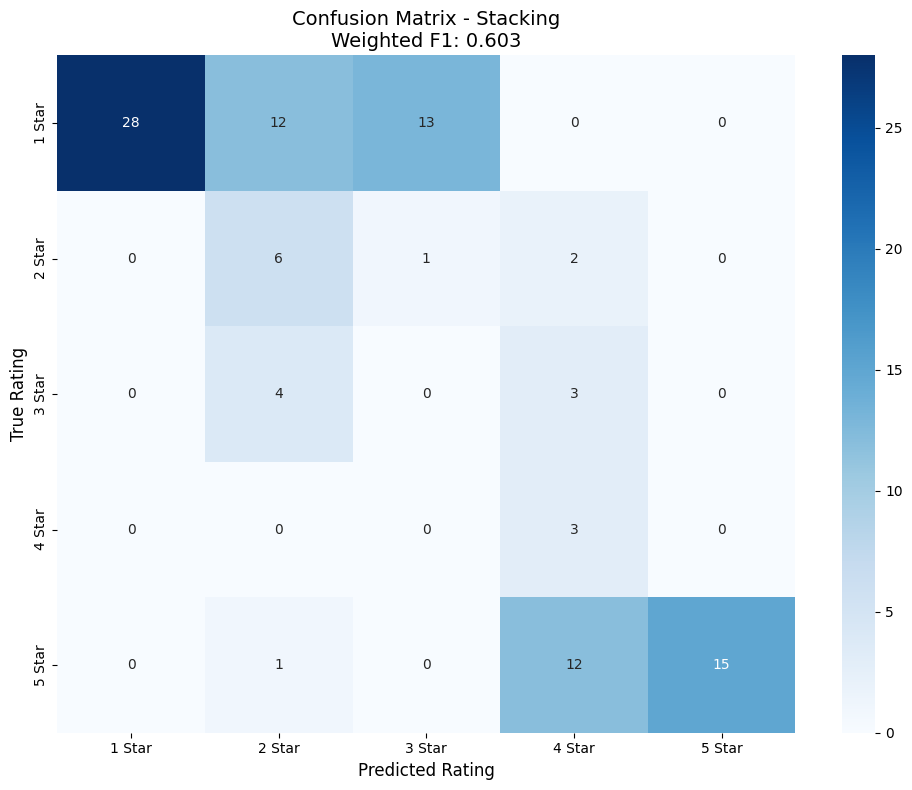

In [28]:

# =============================================================================
# Cell 8: Confusion Matrix Visualization
# =============================================================================

print("\n🔥 Confusion Matrix")
print("=" * 30)

# Create confusion matrix
cm = confusion_matrix(true_ratings, predicted_ratings)
labels = sorted(np.unique(np.concatenate([true_ratings, predicted_ratings])))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=[f"{i} Star" for i in labels],
            yticklabels=[f"{i} Star" for i in labels])
plt.title(f'Confusion Matrix - {model_name}\nWeighted F1: {weighted_f1:.3f}', fontsize=14)
plt.xlabel('Predicted Rating', fontsize=12)
plt.ylabel('True Rating', fontsize=12)
plt.tight_layout()
plt.show()

In [29]:

# =============================================================================
# Cell 9: Error Analysis
# =============================================================================

print("\n🔍 Error Analysis")
print("=" * 30)

# Analyze errors
errors_df = results_df[~results_df['Correct']].copy()

if len(errors_df) > 0:
    print(f"Total errors: {len(errors_df)}")
    
    # Error distribution
    error_diff = errors_df['TrueRating'] - errors_df['PredictedRating']
    
    print(f"\nError patterns:")
    print(f"• Overprediction (predicted > true): {np.sum(error_diff < 0)}")
    print(f"• Underprediction (predicted < true): {np.sum(error_diff > 0)}")
    
    # Show most common errors
    print(f"\nMost common error types:")
    error_types = errors_df.groupby(['TrueRating', 'PredictedRating']).size().sort_values(ascending=False)
    for (true, pred), count in error_types.head(5).items():
        print(f"• True: {true}⭐ → Predicted: {pred}⭐ ({count} times)")
    
    # Show some error examples
    print(f"\n❌ Example errors:")
    for i, (idx, row) in enumerate(errors_df.head(3).iterrows()):
        print(f"\nError {i+1}:")
        print(f"Text: {row['ReviewText']}")
        print(f"True: {row['TrueRating']}⭐ | Predicted: {row['PredictedRating']}⭐")
else:
    print("🎉 No errors found! Perfect predictions!")


🔍 Error Analysis
Total errors: 48

Error patterns:
• Overprediction (predicted > true): 31
• Underprediction (predicted < true): 17

Most common error types:
• True: 1⭐ → Predicted: 3⭐ (13 times)
• True: 1⭐ → Predicted: 2⭐ (12 times)
• True: 5⭐ → Predicted: 4⭐ (12 times)
• True: 3⭐ → Predicted: 2⭐ (4 times)
• True: 3⭐ → Predicted: 4⭐ (3 times)

❌ Example errors:

Error 1:
Text: They are always throwing the packets into the forest behind the mail boxes. Packets are always full of bugs and wet....
True: 1⭐ | Predicted: 2⭐

Error 2:
Text: Just...wow. I'm in shock. I'm a small creator and seller of art online. I've just had a message from another small business telling me that my art has been screenshotted and sold as art by a seller on this website. On further investigation there are ...
True: 1⭐ | Predicted: 2⭐

Error 3:
Text: I had been told I was to pick 3 free gifts because of the many times I have ordered. But, then I never get them and they keep trying to have more purchased. Seems

In [30]:

# =============================================================================
# Cell 10: Summary
# =============================================================================

print("\n" + "=" * 60)
print("🏆 PREDICTION TESTING SUMMARY")
print("=" * 60)

print(f"Model: {model_name}")
print(f"Test samples: {len(test_samples)}")
print(f"Accuracy: {accuracy:.1%}")
print(f"Weighted F1: {weighted_f1:.3f}")
print(f"Macro F1: {macro_f1:.3f}")

# Rating-wise performance
print(f"\nRating distribution in test:")
for rating, count in rating_counts.items():
    correct_for_rating = np.sum((true_ratings == rating) & (predicted_ratings == rating))
    total_for_rating = np.sum(true_ratings == rating)
    if total_for_rating > 0:
        acc_for_rating = correct_for_rating / total_for_rating
        print(f"• {rating}⭐: {correct_for_rating}/{total_for_rating} correct ({acc_for_rating:.1%})")

print(f"\n🎯 Model is ready for production testing!")
print("=" * 60)


🏆 PREDICTION TESTING SUMMARY
Model: Stacking
Test samples: 100
Accuracy: 52.0%
Weighted F1: 0.603
Macro F1: 0.405

Rating distribution in test:
• 1⭐: 28/53 correct (52.8%)
• 2⭐: 6/9 correct (66.7%)
• 3⭐: 0/7 correct (0.0%)
• 4⭐: 3/3 correct (100.0%)
• 5⭐: 15/28 correct (53.6%)

🎯 Model is ready for production testing!


In [31]:

# =============================================================================# 
# Text Preprocessing Functions a copy from the previous notebook because we could not import it
# =============================================================================
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from emoji import demojize
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
import pickle
import sys
# installiere in genau dem Interpreter/Kernel, der gerade läuft
!{sys.executable} -m pip install --quiet --upgrade dill
import dill 
warnings.filterwarnings('ignore')

# Download required NLTK data
# We need these for text processing
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
# =============================================================================

lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean text by removing HTML tags, URLs, special characters
    This is important because review text might contain HTML or URLs
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def remove_special_chars(text):
    """
    Remove special characters and numbers, keep only letters and spaces
    This helps focus on meaningful words for sentiment analysis
    """
    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def convert_emoji_to_sentiment(text):
    """
    Converts emoji descriptions into sentiment categories:
    - positive_emoji
    - negative_emoji
    - neutral_emoji (for any remaining emojis)
    """
    if pd.isna(text):
        return ""

    text = demojize(str(text).lower())

    # Positive emojis
    text = re.sub(r':[^:]*(heart|smil|thumbs_up|grin|laugh|fire|love|kiss|party|celebrate|star|rainbow|sun|cool|awesome|perfect)[^:]*:', ' positive_emoji ', text)

    # Negative emojis (e.g. 💩)
    text = re.sub(r':[^:]*(angry|cry|frown|confus|thumbs_down|sick|vomit|sad|disappoint|tired|worr|broken|poop|shit|pile_of_poo|devil|skull|rage|hate)[^:]*:', ' negative_emoji ', text)

    # Remaining emojis → neutral
    text = re.sub(r':[a-z_]+:', ' neutral_emoji ', text)

    return text

def tokenize_text(text):
    """
    Split text into individual words (tokens)
    This is necessary for further processing like removing stopwords
    """
    if not text:
        return []
    
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    """
    Remove common words like 'the', 'and', 'is' that don't add much meaning
    This reduces noise in our text data
    """
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return filtered_tokens

def lemmatize_tokens(tokens):
    """
    Convert words to their base form (e.g., 'running' -> 'run')
    This helps group similar words together
    """
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

def preprocess_text(text):
    """
    Complete preprocessing pipeline:
    1. Clean text
    2. Remove special characters
    3. Convert Emojis to Text Descriptions
    4. Tokenize
    5. Remove stopwords
    6. Lemmatize
    7. Join back to string
    """
    # Clean text
    text = clean_text(text)
    
    # Remove special characters
    text = remove_special_chars(text)

    # Convert Emojis to Text Descriptions
    text = convert_emoji_to_sentiment(text)
    
    # Tokenize
    tokens = tokenize_text(text)
    
    # Remove stopwords
    tokens = remove_stopwords(tokens)
    
    # Lemmatize
    tokens = lemmatize_tokens(tokens)
    
    # Join back to string
    processed_text = ' '.join(tokens)
    
    return processed_text

def get_sentiment_scores(text):
    """
    Calculate sentiment scores using VADER sentiment analyzer
    This gives us compound, positive, negative, and neutral scores
    """
    if pd.isna(text) or not str(text).strip():
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    
    return sia.polarity_scores(text)

def extract_text_features(text):
    """
    Extract additional features from text:
    - Word count
    - Character count
    - Sentence count
    - Average word length
    - Exclamation marks
    - Question marks
    - Capital letters ratio
    """
    if pd.isna(text):
        return {
            'word_count': 0,
            'char_count': 0,
            'sentence_count': 0,
            'avg_word_length': 0,
            'exclamation_count': 0,
            'question_count': 0,
            'capital_ratio': 0
        }
    
    text = str(text)
    
    # Basic counts
    word_count = len(text.split())
    char_count = len(text)
    sentence_count = len(re.split(r'[.!?]+', text))
    
    # Average word length
    words = text.split()
    avg_word_length = sum(len(word) for word in words) / len(words) if words else 0
    
    # Punctuation counts
    exclamation_count = text.count('!')
    question_count = text.count('?')
    
    # Capital letters ratio
    capital_count = sum(1 for c in text if c.isupper())
    capital_ratio = capital_count / len(text) if text else 0
    
    return {
        'word_count': word_count,
        'char_count': char_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'capital_ratio': capital_ratio
    }

def calculate_sentiment_scores(text):
    """Calculate sentiment scores using NLTK SentimentIntensityAnalyzer"""
    scores = sia.polarity_scores(text)
    return {
        'sentiment_compound': scores['compound'],
        'sentiment_pos': scores['pos'],
        'sentiment_neu': scores['neu'],
        'sentiment_neg': scores['neg']
    }

def preprocess_single_text(text):
    """Complete preprocessing for a single text - same as your preprocessing pipeline"""
    # Use your existing preprocess_text function
    processed_text = preprocess_text(text)
    
    # Extract all features
    text_features = extract_text_features(text)
    sentiment_features = calculate_sentiment_scores(text)
    
    # Combine all features
    all_features = {
        'processed_text': processed_text,
        **text_features,
        **sentiment_features
    }
    
    return all_features

preprocessing_functions = {
    'clean_text': clean_text,
    'remove_special_chars': remove_special_chars, 
    'convert_emoji_to_sentiment': convert_emoji_to_sentiment,
    'tokenize_text': tokenize_text,
    'remove_stopwords': remove_stopwords,
    'lemmatize_tokens': lemmatize_tokens,
    'preprocess_text': preprocess_text,
    'extract_text_features': extract_text_features,
    'calculate_sentiment_scores': calculate_sentiment_scores,
    'preprocess_single_text': preprocess_single_text,
    'lemmatizer': lemmatizer,
    'sia': sia,
    'stop_words': stop_words
}


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text(value="I Love it , it's excellent!", layout=Layout(margin='0 0 15px 0', width='100%'), placeholder="Enter…

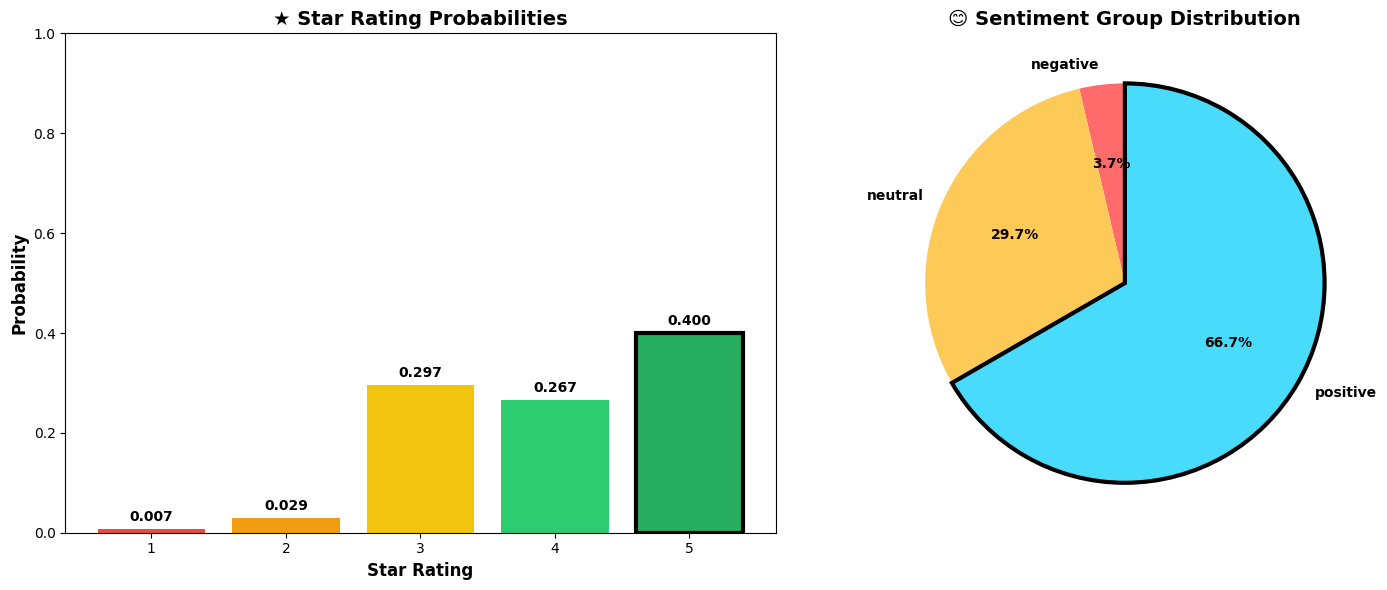

In [ ]:
# =============================================================================
# Cell 11: Interactive Live Prediction Interface
# =============================================================================

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output, HTML
    WIDGETS_AVAILABLE = True
    print("✅ IPywidgets available - Interactive interface will be created")
except ImportError:
    print("❌ IPywidgets not available - Using simple input/output interface")
    WIDGETS_AVAILABLE = False

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import pandas as pd

print("🎯 Setting up Interactive Live Prediction Interface...")
print("=" * 60)

# Store predictions history
prediction_history = []

def preprocess_user_text(text):
    return text.lower().strip()

def make_feature_vector(text: str):
    """
    - führt preprocess_single_text aus
    - liefert (processed_text, num_array) zurück
    """
    feat_dict      = preprocessing_functions["preprocess_single_text"](text)              
    processed_text = feat_dict["processed_text"]               
    num_vector     = [feat_dict[f] for f in numerical_features]
    num_array      = np.array([num_vector])                   
    return processed_text, num_array

def predict_sentiment_live(text):
    """Make prediction for user input with detailed analysis"""
    if not text.strip():
        print("⚠️ Please enter some text!")
        return None, None, None, None
    
    print(f"🔄 Processing text: '{text[:200]}{'...' if len(text) > 200 else ''}'")
    
    try:
        # Preprocess text
        processed_text = preprocess_user_text(text)
        
        #display(HTML(f"""
        #<h3 style="color: #2c3e50; margin-top: 0;">🎯 {processed_text}</h3>
        #"""))
                     
        print(f"✅ Text preprocessed: '{processed_text[:200]}{'...' if len(processed_text) > 200 else ''}'")

        dummy_size = len(numerical_features) # I need to check this
        dummy_numerical = np.array([[0.5] * dummy_size])
        
        # TF-IDF transformation
        tfidf_features = tfidf_vectorizer.transform([processed_text])
        print(f"✅ TF-IDF features created: {tfidf_features.shape}")
        
        # Scale numerical features
        numerical_features_scaled = scaler.transform(dummy_numerical)

        # 1. Features
        #processed_text, num_array = make_feature_vector(text)
        #print(f"✅ Text preprocessed: '{processed_text[:200]}{'...' if len(processed_text) > 200 else ''}'")

        # 2. TF-IDF und Skalierung
        #tfidf_features            = tfidf_vectorizer.transform([processed_text])
        #numerical_features_scaled = scaler.transform(num_array)

        # 3. Combine features
        combined_features = hstack([tfidf_features, numerical_features_scaled])
        print(f"✅ Combined features: {combined_features.shape}")

        print("\n🔮 Making predictions...")

        predicted_rating = best_model.predict(combined_features)

        prediction_probs = best_model.predict_proba(combined_features)  

        # Make prediction with penalty applied (same as in your code)
        if APPLY_PENALTY and hasattr(best_model, "predict_proba"):
            proba = best_model.predict_proba(combined_features).copy()
            
            # Apply 20% penalty to class 3★
            idx_3 = list(best_model.classes_).index(3)
            proba[:, idx_3] *= 0.8
            proba = proba / proba.sum(axis=1, keepdims=True)
            
            # Final prediction
            predicted_rating = best_model.classes_[proba.argmax(axis=1)][0]

            # Apply 20% penalty to class 3★
            idx_3 = list(best_model.classes_).index(3)
            proba[:, idx_3] *= 1
            proba = proba / proba.sum(axis=1, keepdims=True)

            prediction_probs = proba[0]
            print("✅ Applied 20% penalty to 3-star predictions")
        else:
            print("ℹ️ Penalty not applied (either disabled or model has no predict_proba)")
        
        print(f"🎯 Initial prediction: {predicted_rating} stars")
        
        # Determine sentiment group and refined prediction
        group_of = {1: "negative", 2: "negative", 3: "neutral", 4: "positive", 5: "positive"}
        predicted_group = group_of[predicted_rating]
        
        # Refine prediction based on group probabilities
        if prediction_probs is not None:
            # Map class indices to their probabilities
            class_indices = {cls: idx for idx, cls in enumerate(best_model.classes_)}

            # Extract probabilities for each class
            p1 = prediction_probs[class_indices[1]] if 1 in class_indices else 0
            p2 = prediction_probs[class_indices[2]] if 2 in class_indices else 0
            p3 = prediction_probs[class_indices[3]] if 3 in class_indices else 0
            p4 = prediction_probs[class_indices[4]] if 4 in class_indices else 0
            p5 = prediction_probs[class_indices[5]] if 5 in class_indices else 0

            # Calculate group probabilities
            p_neg = p1 + p2
            p_neu = p3 
            p_pos = p4 + p5

            # Refined prediction logic
            if p_neu >= p_neg and p_neu >= p_pos:
                predicted_group = "neutral"
                refined_rating = 3

            elif p_neg >= p_pos:                  
                predicted_group = "negative"
                refined_rating = 1 if p1 >= p2 else 2

            else:                                   
                predicted_group = "positive"
                refined_rating = 4 if p4 >= p5 else 5

        else:
            # No probabilities available, use initial prediction
            predicted_group = {1: "negative", 2: "negative", 3: "neutral",
                            4: "positive", 5: "positive"}[predicted_rating]
            refined_rating = predicted_rating
        
        print(f"🌟 Final refined prediction: {refined_rating} stars ({predicted_group})")
        return predicted_rating, refined_rating, predicted_group, prediction_probs
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

def create_prediction_visualization(text, predicted_rating, refined_rating, group, probabilities):
    """Create a beautiful visualization of the prediction results"""
    
    # Clear previous output
   # clear_output(wait=True)
    
    # Display header
    display(HTML(f"""
    <div style="background: linear-gradient(90deg, #667eea 0%, #764ba2 100%); 
                padding: 20px; border-radius: 10px; margin: 10px 0;">
        <h2 style="color: white; text-align: center; margin: 0;">
            🌟 Live Sentiment Analysis Results 🌟
        </h2>
    </div>
    """))
    
    # Create results display
    group_colors = {
        "negative": "#ff6b6b",
        "neutral": "#feca57", 
        "positive": "#48dbfb"
    }
    
    group_emojis = {
        "negative": "😞",
        "neutral": "😐",
        "positive": "😊"
    }
    
    color = group_colors.get(group, "#95a5a6")
    emoji = group_emojis.get(group, "🤔")
    
    # Text analysis section
    display(HTML(f"""
    <div style="background: white; padding: 20px; border-radius: 10px; 
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); margin: 10px 0;">
        <h3 style="color: #2c3e50; margin-top: 0;">📝 Input Text Analysis</h3>
        <div style="background: #f8f9fa; padding: 15px; border-radius: 8px; 
                    border-left: 4px solid {color};">
            <p style="font-size: 16px; margin: 0; line-height: 1.5;">
                <strong>Original Text:</strong><br>
                <em>"{text}"</em>
            </p>
        </div>
    </div>
    """))
    
    # Prediction results section
    display(HTML(f"""
    <div style="background: white; padding: 20px; border-radius: 10px; 
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); margin: 10px 0;">
        <h3 style="color: #2c3e50; margin-top: 0;">🎯 Prediction Results</h3>
        
        <div style="display: flex; justify-content: space-around; flex-wrap: wrap;">
            <div style="text-align: center; padding: 15px; background: {color}; 
                        color: white; border-radius: 10px; margin: 5px; min-width: 150px;">
                <h4 style="margin: 0;">Sentiment Group</h4>
                <div style="font-size: 24px; margin: 10px 0;">{emoji}</div>
                <div style="font-size: 18px; font-weight: bold;">{group.upper()}</div>
            </div>
            
            <div style="text-align: center; padding: 15px; background: #3498db; 
                        color: white; border-radius: 10px; margin: 5px; min-width: 150px;">
                <h4 style="margin: 0;">Initial Prediction</h4>
                <div style="font-size: 24px; margin: 10px 0;">⭐</div>
                <div style="font-size: 18px; font-weight: bold;">{predicted_rating} Stars</div>
            </div>
            
            <div style="text-align: center; padding: 15px; background: #27ae60; 
                        color: white; border-radius: 10px; margin: 5px; min-width: 150px;">
                <h4 style="margin: 0;">Refined Prediction</h4>
                <div style="font-size: 24px; margin: 10px 0;">🎯</div>
                <div style="font-size: 18px; font-weight: bold;">{refined_rating} Stars</div>
            </div>
        </div>
    </div>
    """))
    
    # Probability visualization
    if probabilities is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Star ratings probability bar chart
        stars = list(best_model.classes_)
        probs = probabilities
        colors_bars = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']
        
        bars = ax1.bar(stars, probs, color=colors_bars[:len(stars)])
        ax1.set_xlabel('Star Rating', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax1.set_title('★ Star Rating Probabilities', fontsize=14, fontweight='bold')
        ax1.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Highlight the predicted rating
        predicted_idx = list(stars).index(refined_rating)
        bars[predicted_idx].set_edgecolor('black')
        bars[predicted_idx].set_linewidth(3)
        
        p1, p2, p3, p4, p5 = probs               
                        
        # Calculate group probabilities based on refined logic
        group_probs = {
            "negative": p1 +  p2,   
            "neutral" : p3 ,
            "positive": p5 + p4        
        }

        # Sentiment group probabilities pie chart
        groups        = list(group_probs.keys())
        group_values  = list(group_probs.values())
        group_colors_pie = [group_colors[g] for g in groups]

        wedges, texts, autotexts = ax2.pie(
            group_values,
            labels=groups,
            colors=group_colors_pie,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontweight': 'bold'}
        )
        ax2.set_title('😊 Sentiment Group Distribution', fontsize=14, fontweight='bold')

        # Highlight der vorher gewählten Gruppe
        for i, g in enumerate(groups):
            if g == group:                 # ← kommt aus deinem Refinement-Code
                wedges[i].set_edgecolor('black')
                wedges[i].set_linewidth(3)
        
        plt.tight_layout()
        plt.show()

def on_submit_click(b):
    """Handle submit button click"""
    text = text_input.value.strip()
    if text:
        # Add to history
        timestamp = datetime.now().strftime("%H:%M:%S")
        
        # Make prediction
        pred_rating, refined_rating, group, probs = predict_sentiment_live(text)
        
        if pred_rating is not None:
            # Store in history
            prediction_history.append({
                'timestamp': timestamp,
                'text': text,
                'predicted_rating': pred_rating,
                'refined_rating': refined_rating,
                'sentiment_group': group
            })
            
            
            # Show input interface again
            display_interface()

            # Create visualization
            create_prediction_visualization(text, pred_rating, refined_rating, group, probs)
        
            # Show probabilities if available
            if probs is not None:
                print(f"\n📊 Star Rating Probabilities:")
                for star, prob in zip(best_model.classes_, probs):
                    bar_length = int(prob * 20)  # Scale to 20 chars
                    bar = "█" * bar_length + "░" * (20 - bar_length)
                    print(f"   {star}⭐: {bar} {prob:.3f}")
            
        else:
            print("❌ Could not make prediction. Please try again.")

def on_back_click(b):
    clear_output(wait=True) 
    display_interface()        

def on_clear_click(b):
    """Handle clear button click"""
    text_input.value = ""
    clear_output(wait=True)
    display_interface()

def on_history_click(b):
    """Show prediction history"""
    if prediction_history:
        clear_output(wait=True)
        
        display(HTML("""
        <div style="background: linear-gradient(90deg, #667eea 0%, #764ba2 100%); 
                    padding: 20px; border-radius: 10px; margin: 10px 0;">
            <h2 style="color: white; text-align: center; margin: 0;">
                📚 Prediction History
            </h2>
        </div>
        """))
        
        # Create history table
        history_df = pd.DataFrame(prediction_history)
        
        html_table = """
        <div style="background: white; padding: 20px; border-radius: 10px; 
                    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); margin: 10px 0;">
            <table style="width: 100%; border-collapse: collapse;">
                <tr style="background: #3498db; color: white;">
                    <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Time</th>
                    <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Text (Preview)</th>
                    <th style="padding: 12px; text-align: center; border: 1px solid #ddd;">Initial</th>
                    <th style="padding: 12px; text-align: center; border: 1px solid #ddd;">Refined</th>
                    <th style="padding: 12px; text-align: center; border: 1px solid #ddd;">Sentiment</th>
                </tr>
        """
        
        for _, row in history_df.iterrows():
            text_preview = row['text'][:200] + "..." if len(row['text']) > 200 else row['text']
            sentiment_emoji = {"negative": "😞", "neutral": "😐", "positive": "😊"}.get(row['sentiment_group'], "🤔")
            
            html_table += f"""
                <tr style="border-bottom: 1px solid #ddd;">
                    <td style="padding: 10px; border: 1px solid #ddd;">{row['timestamp']}</td>
                    <td style="padding: 10px; border: 1px solid #ddd;"><em>"{text_preview}"</em></td>
                    <td style="padding: 10px; text-align: center; border: 1px solid #ddd;">{row['predicted_rating']}⭐</td>
                    <td style="padding: 10px; text-align: center; border: 1px solid #ddd; font-weight: bold;">{row['refined_rating']}⭐</td>
                    <td style="padding: 10px; text-align: center; border: 1px solid #ddd;">{sentiment_emoji} {row['sentiment_group']}</td>
                </tr>
            """
        
        html_table += "</table></div>"
        display(HTML(html_table))
        
        # Back to interface button
        back_button = widgets.Button(
            description="🔙 Back to Interface",
            button_style='info',
            layout=widgets.Layout(width='200px', height='40px')
        )
        back_button.on_click(on_back_click)
   
        display(back_button)
    else:
        print("📝 No predictions made yet!")

def display_interface():
    """Display the main input interface"""
    clear_output(wait=True)
    
    # Header
    display(HTML("""
    <div style="background: linear-gradient(90deg, #667eea 0%, #764ba2 100%); 
                padding: 20px; border-radius: 10px; margin: 10px 0;">
        <h2 style="color: white; text-align: center; margin: 0;">
            🎭 Live Sentiment Analysis Interface
        </h2>
        <p style="color: white; text-align: center; margin: 10px 0 0 0;">
            Enter your review text below and get instant star rating prediction!
        </p>
    </div>
    """))
    
    # Instructions
    display(HTML("""
    <div style="background: #ecf0f1; padding: 15px; border-radius: 8px; margin: 10px 0;">
        <h4 style="color: #2c3e50; margin-top: 0;">📋 Instructions:</h4>
        <ul style="color: #34495e;">
            <li><strong>Enter Text:</strong> Type your review in the text area below</li>
            <li><strong>Submit:</strong> Click "🎯 Predict Rating" or press Ctrl+Enter</li>
            <li><strong>Clear:</strong> Click "🧹 Clear" to reset the input</li>
            <li><strong>History:</strong> View all previous predictions</li>
        </ul>
    </div>
    """))
    
    # Input interface
    display(text_input)
    display(widgets.HBox([submit_button, clear_button, history_button],))

# Alternative simple interface if widgets are not available
def simple_interface():
    """Simple input/output interface without widgets"""
    print("🎭 Simple Live Sentiment Analysis Interface")
    print("=" * 50)
    print("💡 Enter your text when prompted, press Enter to predict")
    print("💡 Type 'quit' or 'exit' to stop, 'history' to see previous predictions")
    print("-" * 50)
    
    while True:
        try:
            text = input("\n📝 Enter your review text (or 'quit' to exit): ").strip()
            
            if text.lower() in ['quit', 'exit', 'q']:
                print("👋 Goodbye!")
                break
            elif text.lower() == 'history':
                if prediction_history:
                    print("\n📚 Prediction History:")
                    print("-" * 60)
                    for i, pred in enumerate(prediction_history, 1):
                        print(f"{i}. [{pred['timestamp']}] \"{pred['text'][:200]}{'...' if len(pred['text']) > 200 else ''}\"")
                        print(f"   → {pred['refined_rating']}⭐ ({pred['sentiment_group']})")
                else:
                    print("📝 No predictions made yet!")
                continue
            elif not text:
                print("⚠️ Please enter some text!")
                continue
            
            # Make prediction
            print(f"\n🔄 Analyzing: '{text}'")
            pred_rating, refined_rating, group, probs = predict_sentiment_live(text)
            
            if pred_rating is not None:
                # Add to history
                timestamp = datetime.now().strftime("%H:%M:%S")
                prediction_history.append({
                    'timestamp': timestamp,
                    'text': text,
                    'predicted_rating': pred_rating,
                    'refined_rating': refined_rating,
                    'sentiment_group': group
                })
                
                # Simple text output
                print("\n" + "="*60)
                print("🌟 PREDICTION RESULTS")
                print("="*60)
                print(f"📝 Text: \"{text}\"")
                print(f"🎯 Initial Prediction: {pred_rating} ⭐")
                print(f"🌟 Refined Prediction: {refined_rating} ⭐")
                
                # Sentiment group with emoji
                group_emojis = {"negative": "😞", "neutral": "😐", "positive": "😊"}
                emoji = group_emojis.get(group, "🤔")
                print(f"😊 Sentiment Group: {emoji} {group.upper()}")
                
                # Show probabilities if available
                if probs is not None:
                    print(f"\n📊 Star Rating Probabilities:")
                    for star, prob in zip(best_model.classes_, probs):
                        bar_length = int(prob * 20)  # Scale to 20 chars
                        bar = "█" * bar_length + "░" * (20 - bar_length)
                        print(f"   {star}⭐: {bar} {prob:.3f}")
                
                # Create simple matplotlib visualization
                if probs is not None:
                    try:
                        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
                        
                        stars = list(best_model.classes_)
                        colors = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60'][:len(stars)]
                        
                        bars = ax.bar(stars, probs, color=colors)
                        ax.set_xlabel('Star Rating', fontsize=12, fontweight='bold')
                        ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
                        ax.set_title(f'🌟 Prediction: {refined_rating}⭐ ({group.upper()})', fontsize=14, fontweight='bold')
                        ax.set_ylim(0, 1)
                        
                        # Highlight predicted rating
                        predicted_idx = list(stars).index(refined_rating)
                        bars[predicted_idx].set_edgecolor('black')
                        bars[predicted_idx].set_linewidth(3)
                        
                        # Add value labels
                        for bar, prob in zip(bars, probs):
                            height = bar.get_height()
                            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                                   f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
                        
                        plt.tight_layout()
                        plt.show()
                    except Exception as e:
                        print(f"⚠️ Could not create chart: {e}")
                
                print("="*60)
            else:
                print("❌ Could not make prediction. Please try again.")
                
        except KeyboardInterrupt:
            print("\n👋 Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error: {e}")

# Check if all required variables are available
required_vars = ['best_model', 'tfidf_vectorizer', 'scaler']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"❌ Missing required variables: {missing_vars}")
    print("💡 Please run the previous cells to load the model and data first!")
else:
    print("✅ All required variables available!")
    
    if WIDGETS_AVAILABLE:
        # Try to create widgets interface
        try:
           
            text_input = widgets.Text(   
                placeholder="Enter your review text here... (e.g., 'This product is amazing, I love it!')",
                layout=widgets.Layout(width='100%', margin='0 0 15px 0'),
                style={'description_width': '0px'}
            )

            submit_button = widgets.Button(
                description="🎯 Predict Rating",
                button_style='success',
                layout=widgets.Layout(width='150px', height='40px')
            )
            clear_button = widgets.Button(
                description="🧹 Clear",
                button_style='warning',
                layout=widgets.Layout(width='100px', height='40px')
            )
            history_button = widgets.Button(
                description="📚 View History",
                button_style='info',
                layout=widgets.Layout(width='150px', height='40px')
            )

            # Events binden
            submit_button.on_click(on_submit_click)
            clear_button.on_click(on_clear_click)
            history_button.on_click(on_history_click)

            def handle_submit(sender):
                on_submit_click(None)

            text_input.on_submit(handle_submit) 

            print("✅ Interactive widgets interface ready!")
            display_interface()
            
        except Exception as e:
            print(f"⚠️ Could not create widgets interface: {e}")
            print("🔄 Falling back to simple interface...")
            WIDGETS_AVAILABLE = False
    
    if not WIDGETS_AVAILABLE:
        # Use simple interface
        print("🔄 Using simple text-based interface...")
        simple_interface()